In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from xgboost import plot_importance
import gc

def delifexistslist(varlist):
    for var in varlist:
        if var in globals():
            del var
    gc.collect()

In [2]:
train = pd.read_csv('predictFutureSalesClean.csv')
items = pd.read_csv("items.csv")
test = pd.read_csv("test.csv")

In [3]:
#add more columns for feature engineering
all_data = train
all_data['date'] = pd.to_datetime(all_data.date, format='%Y.%m.%d')
all_data['year_month'] = all_data.date.dt.strftime("%Y%m")
all_data['date_week'] = all_data.date.dt.week
all_data['dayofweek_name'] = all_data.date.dt.day_name()
all_data['dayofweek_no'] = all_data.date.dt.dayofweek 
all_data['wrk_week'] = np.where(all_data['date_year']==2013, 
                                all_data['date_week'], 
                        np.where(all_data['date_year']==2014, 
                                all_data['date_week']+52, 
                                all_data['date_week']+104))

In [4]:
all_data

,Unnamed: 0,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,Required,item_category_name,date_month,date_year,total_sales,year_month,date_week,dayofweek_name,dayofweek_no,wrk_week
0,0,2013-01-02,0,59,22154,999.0,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,True,Кино - Blu-Ray,1,2013,999.0,201301,1,Wednesday,2,1
1,1,2013-01-03,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,798.0,201301,1,Thursday,3,1
2,2,2013-01-05,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,399.0,201301,1,Saturday,5,1
3,3,2013-01-07,0,25,2574,399.0,1.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,399.0,201301,2,Monday,0,2
4,4,2013-01-08,0,25,2574,399.0,2.0,"Москва ТРК ""Атриум""",DEL REY LANA Born To Die The Paradise Editio...,55,True,Музыка - CD локального производства,1,2013,798.0,201301,2,Tuesday,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1442559,1442559,2015-10-10,33,25,7409,299.0,1.0,"Москва ТРК ""Атриум""",V/A Nu Jazz Selection (digipack),55,True,Музыка - CD локального производства,10,2015,299.0,201510,41,Saturday,5,145
1442560,1442560,2015-10-09,33,25,7460,299.0,1.0,"Москва ТРК ""Атриум""",V/A The Golden Jazz Collection 1 2CD,55,True,Музыка - CD локального производства,10,2015,299.0,201510,41,Friday,4,145
1442561,1442561,2015-10-14,33,25,7459,349.0,1.0,"Москва ТРК ""Атриум""",V/A The Best Of The 3 Tenors,55,True,Музыка - CD локального производства,10,2015,349.0,201510,42,Wednesday,2,146
1442562,1442562,2015-10-22,33,25,7440,299.0,1.0,"Москва ТРК ""Атриум""",V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,True,Музыка - MP3,10,2015,299.0,201510,43,Thursday,3,147


In [4]:
itemCntDayGrouped = all_data.groupby(['item_id','shop_id','date_block_num'])[['item_cnt_day']].agg('sum').reset_index()

In [5]:
#Populate a list of required product and shop for kaggle submission
#This code will ensure that all the product and shop to be available
#in the data frame regardless there are sales/item count or not. 
testTemp=test.drop(columns=['ID']).reset_index()
#Recreate a empty data frame
salesTable=pd.DataFrame({'date_block_num':[0],'shop_id':[0],'item_id':[0]})
for i in range(34):  
    testTemp['date_block_num']=i
    testTemp2=testTemp.set_index(['date_block_num','shop_id','item_id'])
    salesPPX=itemCntDayGrouped[itemCntDayGrouped.date_block_num==i].set_index(['date_block_num','shop_id','item_id'])
    testTemp2=testTemp2.join(salesPPX).reset_index().fillna(0)
    salesTable=salesTable.append(testTemp2)
    
#delifexistslist(['testTemp','salesPPX','testTemp2'])

In [6]:
#Add Test Data month 34 as well
test_data=test.reset_index().drop(columns=['ID'])
test_data['date_block_num']=34

salesTable=salesTable.append(test_data).fillna(0)
salesTable.drop(columns=['index'])

,date_block_num,shop_id,item_id,item_cnt_day
0,0,0,0,0.0
0,0,5,5037,0.0
1,0,5,5320,0.0
2,0,5,5233,0.0
3,0,5,5232,0.0
...,...,...,...,...
214195,34,45,18454,0.0
214196,34,45,16188,0.0
214197,34,45,15757,0.0
214198,34,45,19648,0.0


In [7]:
#Calculate lag for all
def populateLag(all_data, lags): 
    tmp = all_data[['date_block_num','shop_id','item_id','item_cnt_day']]
    i = 1
    while i in range(lags):
        shifted = tmp.copy()
        columnName = 'lags: ' + str(i)
        shifted=shifted.rename(columns={'item_cnt_day':columnName})
        shifted['date_block_num'] += i
        shifted=shifted.set_index(['date_block_num','shop_id','item_id'])
        all_data=all_data.set_index(['date_block_num','shop_id','item_id']).join(shifted).reset_index()
        i += 1
    return all_data.fillna(0)

In [8]:
itemCntLag = populateLag(salesTable, 4)

In [9]:
itemCntLag = itemCntLag.drop(columns=['index'])

In [10]:
itemCntLag

,date_block_num,shop_id,item_id,item_cnt_day,lags: 1,lags: 2,lags: 3
0,0,0,0,0.0,0.0,0.0,0.0
1,0,5,5037,0.0,0.0,0.0,0.0
2,0,5,5320,0.0,0.0,0.0,0.0
3,0,5,5233,0.0,0.0,0.0,0.0
4,0,5,5232,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7496996,34,45,18454,0.0,1.0,0.0,0.0
7496997,34,45,16188,0.0,0.0,0.0,0.0
7496998,34,45,15757,0.0,0.0,0.0,0.0
7496999,34,45,19648,0.0,0.0,0.0,0.0


In [32]:
itemCntLag[itemCntLag.date_block_num==34].count()

date_block_num    214200
shop_id           214200
item_id           214200
item_cnt_day      214200
lags: 1           214200
lags: 2           214200
lags: 3           214200
dtype: int64

In [11]:
SalesTest=pd.read_csv('test.csv').set_index(['shop_id','item_id'])
#normData.item_cnt_day[normData.item_cnt_day>20]=20
ModelData201509=itemCntLag[itemCntLag.date_block_num==32]
ModelData201509y=SalesTest.join(ModelData201509.set_index(['shop_id','item_id']).item_cnt_day).fillna(0).item_cnt_day.values
ModelData201510=itemCntLag[itemCntLag.date_block_num==33]
ModelData201510y=SalesTest.join(ModelData201510.set_index(['shop_id','item_id']).item_cnt_day).fillna(0).item_cnt_day.values
#Lets check RSME value if 201509 is used as prediction for 201510
rms = mean_squared_error(ModelData201510y, ModelData201509y, squared=False)
print('RMSE for 201509->201510 Regession:'+str(rms))

RMSE for 201509->201510 Regession:4.767715502325103


In [12]:
normData = itemCntLag

In [13]:
#Create Train, Validation Set
x_train=normData[normData.date_block_num<33].drop(columns=['item_cnt_day'])
y_train=normData[(normData.date_block_num<33)]['item_cnt_day'].values
x_valid=normData[normData.date_block_num==33].drop(columns=['item_cnt_day'])
y_valid=normData[normData.date_block_num==33]['item_cnt_day'].values
x_target=normData[normData.date_block_num==34].drop(columns=['item_cnt_day'])

In [14]:
%%time
model4 = XGBRegressor(
    max_depth=10,
    booster='gbtree',
    n_estimators=50,
    min_child_weight=0.5, 
    subsample=0.8,
    sampling_method="uniform",
    colsample_bynode=1,
    colsample_bytree=0.8, 
    eta=0.1,
    seed=0)

model4.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:3.07802	validation_1-rmse:5.47705
[1]	validation_0-rmse:2.92112	validation_1-rmse:5.37167
[2]	validation_0-rmse:2.75612	validation_1-rmse:5.31607
[3]	validation_0-rmse:2.65715	validation_1-rmse:5.25617
[4]	validation_0-rmse:2.56230	validation_1-rmse:5.21603
[5]	validation_0-rmse:2.49139	validation_1-rmse:5.17947
[6]	validation_0-rmse:2.38487	validation_1-rmse:5.14563
[7]	validation_0-rmse:2.32016	validation_1-rmse:5.10903
[8]	validation_0-rmse:2.24503	validation_1-rmse:5.07032
[9]	validation_0-rmse:2.19470	validation_1-rmse:5.05028
[10]	validation_0-rmse:2.13332	validation_1-rmse:5.01834
[11]	validation_0-rmse:2.07487	validation_1-rmse:4.98349
[12]	validation_0-rmse:2.02694	validation_1-rmse:4.95331
[13]	validation_0-rmse:1.99855	validation_1-rmse:4.94004
[14]	validation_0-rmse:1.95827	validation_1-rmse:4.91888
[15]	validation_0-rmse:1.93630	validation_1-rmse:4.90722
[16]	validation_0-rmse:1.90196	validation_1-rmse:4.89130
[17]	validation_0-rmse:1.88495	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, sampling_method='uniform',
             scale_pos_weight=1, seed=0, subsample=0.8, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [18]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model4, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.66


In [36]:
print("K-fold standard deviation score: %.2f" % kf_cv_scores.std())

K-fold standard deviation score: 0.07


In [15]:
modelOutput = model4.predict(x_target)

In [16]:
modelOutput

array([0.6453813 , 0.09233544, 1.1635711 , ..., 0.06426983, 0.06426983,
       0.04641465], dtype=float32)

In [17]:
x_target

,date_block_num,shop_id,item_id,lags: 1,lags: 2,lags: 3
7282801,34,5,5037,0.0,1.0,3.0
7282802,34,5,5320,0.0,0.0,0.0
7282803,34,5,5233,1.0,3.0,1.0
7282804,34,5,5232,0.0,0.0,1.0
7282805,34,5,5268,0.0,0.0,0.0
...,...,...,...,...,...,...
7496996,34,45,18454,1.0,0.0,0.0
7496997,34,45,16188,0.0,0.0,0.0
7496998,34,45,15757,0.0,0.0,0.0
7496999,34,45,19648,0.0,0.0,0.0


In [18]:
modelOutput

array([0.6453813 , 0.09233544, 1.1635711 , ..., 0.06426983, 0.06426983,
       0.04641465], dtype=float32)

In [19]:
x_target['item_cnt_day'] = modelOutput

x_target

,date_block_num,shop_id,item_id,lags: 1,lags: 2,lags: 3,item_cnt_day
7282801,34,5,5037,0.0,1.0,3.0,0.645381
7282802,34,5,5320,0.0,0.0,0.0,0.092335
7282803,34,5,5233,1.0,3.0,1.0,1.163571
7282804,34,5,5232,0.0,0.0,1.0,0.232251
7282805,34,5,5268,0.0,0.0,0.0,0.092335
...,...,...,...,...,...,...,...
7496996,34,45,18454,1.0,0.0,0.0,0.244076
7496997,34,45,16188,0.0,0.0,0.0,0.064270
7496998,34,45,15757,0.0,0.0,0.0,0.064270
7496999,34,45,19648,0.0,0.0,0.0,0.064270


In [20]:
combinedData = itemCntLag.append(x_target,ignore_index=False)

#itemCntLag = itemCntLag['date_block_num'].astype(float)

In [21]:
combinedData

,date_block_num,shop_id,item_id,item_cnt_day,lags: 1,lags: 2,lags: 3
0,0,0,0,0.000000,0.0,0.0,0.0
1,0,5,5037,0.000000,0.0,0.0,0.0
2,0,5,5320,0.000000,0.0,0.0,0.0
3,0,5,5233,0.000000,0.0,0.0,0.0
4,0,5,5232,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...
7496996,34,45,18454,0.244076,1.0,0.0,0.0
7496997,34,45,16188,0.064270,0.0,0.0,0.0
7496998,34,45,15757,0.064270,0.0,0.0,0.0
7496999,34,45,19648,0.064270,0.0,0.0,0.0


In [22]:
combinedData = combinedData.groupby(['date_block_num'])[['item_cnt_day']].agg('sum').reset_index()

In [23]:
combinedData

,date_block_num,item_cnt_day
0,0,20671.000000
1,1,22227.000000
2,2,31632.000000
3,3,20746.000000
4,4,23350.000000
5,5,32540.000000
6,6,29999.000000
7,7,32407.000000
8,8,44148.000000
9,9,39823.000000


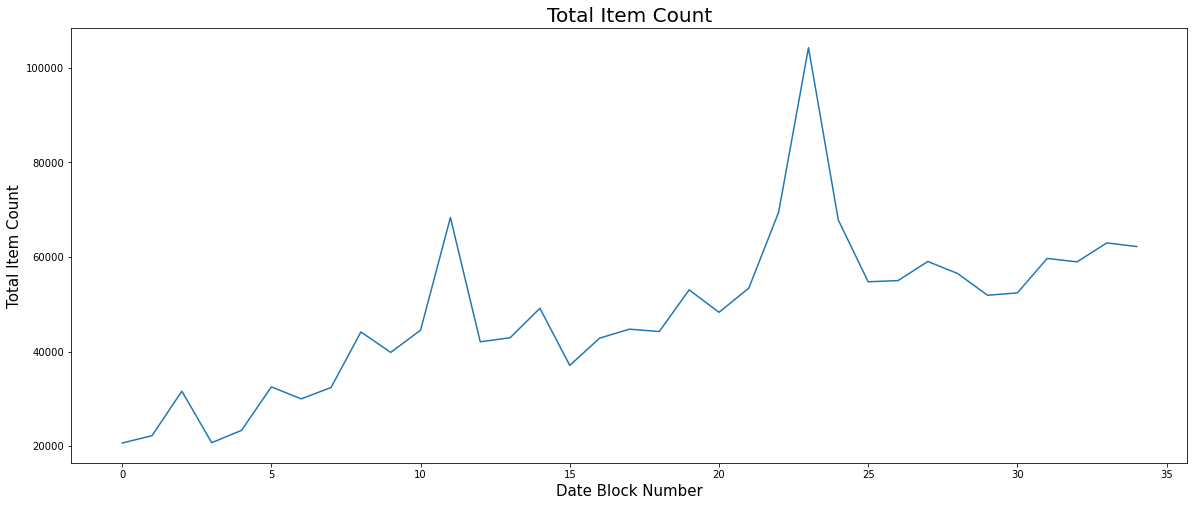

In [24]:
fig0,ax0=plt.subplots(figsize=(20,8));
sns.lineplot(x='date_block_num', y = 'item_cnt_day', data = combinedData)

plt.title("Total Item Count", fontsize = 20)
plt.xlabel("Date Block Number", fontsize = 15)
plt.ylabel("Total Item Count", fontsize = 15)
#legend = ax0.legend()
#legend.texts[0].set_text("Year")
plt.show()

In [25]:
Predictions = np.rint(modelOutput)
Predictions
df = pd.DataFrame(Predictions)

In [31]:
df

,0
0,1.0
1,0.0
2,1.0
3,0.0
4,0.0
...,...
214195,0.0
214196,0.0
214197,0.0
214198,0.0


In [26]:
SalesTest1=pd.read_csv('test.csv')
SalesTest=SalesTest1.set_index(['shop_id','item_id'])

<ipython-input-27-7787a24bb8fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PredsDF['item_cnt_month']=Predictions


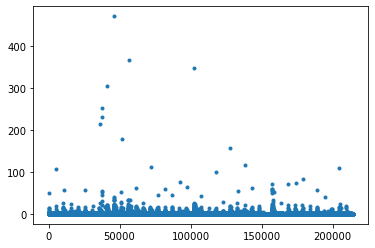

In [27]:
#PredsDF=x_target[['shop_id','item_id']]
#PredsDF['item_cnt_month']=Predictions
Submission=SalesTest.join(PredsDF.set_index(['shop_id','item_id'])).reset_index().drop(columns=['shop_id','item_id'])
plt.plot(Submission.item_cnt_month,'.')

,ID,item_cnt_month
0,0,0.0
1,1,0.0
2,2,1.0
3,3,0.0
4,4,0.0
...,...,...
214195,214195,0.0
214196,214196,0.0
214197,214197,0.0
214198,214198,0.0


In [29]:
Submission.to_csv('submission10.csv',index=False)

In [30]:
model4.get_booster().get_score(importance_type='weight')

{'lags: 2': 4139,
 'lags: 3': 2295,
 'date_block_num': 7811,
 'shop_id': 7266,
 'lags: 1': 2244,
 'item_id': 4508}

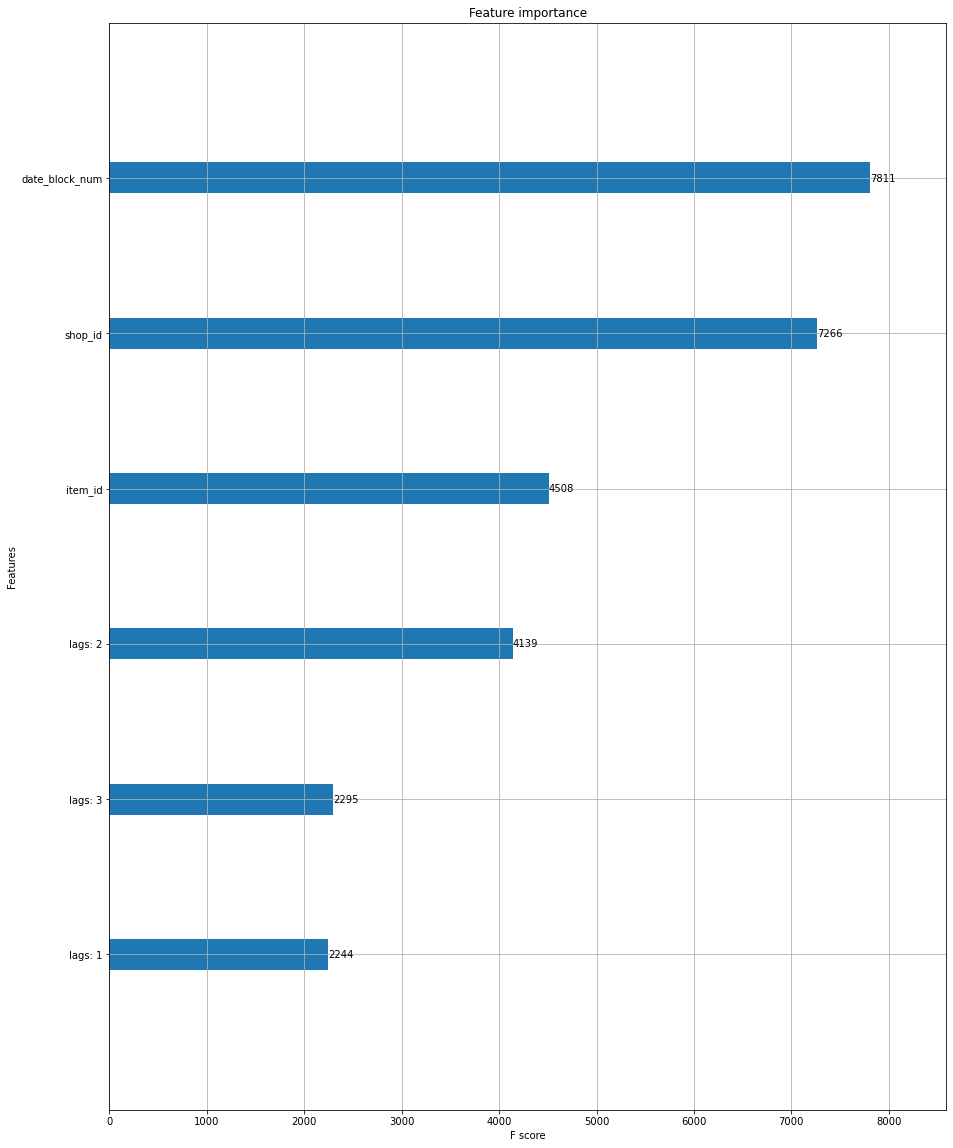

In [33]:
fig, ax = plt.subplots(1,1,figsize=(15,20))
plot_importance(booster=model4, ax=ax)